In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
import string
import re

In [7]:
path=r'Combined Data.csv'
df=pd.read_csv(path)
df['Description']=df['statement']
df

,Unnamed: 0,statement,status,Description
0,0,oh my gosh,Anxiety,oh my gosh
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety,"trouble sleeping, confused mind, restless hear..."
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,"All wrong, back off dear, forward doubt. Stay ..."
3,3,I've shifted my focus to something else but I'...,Anxiety,I've shifted my focus to something else but I'...
4,4,"I'm restless and restless, it's been a month n...",Anxiety,"I'm restless and restless, it's been a month n..."
...,...,...,...,...
53038,53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety,Nobody takes me seriously I’ve (24M) dealt wit...
53039,53039,"selfishness ""I don't feel very good, it's lik...",Anxiety,"selfishness ""I don't feel very good, it's lik..."
53040,53040,Is there any way to sleep better? I can't slee...,Anxiety,Is there any way to sleep better? I can't slee...
53041,53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety,"Public speaking tips? Hi, all. I have to give ..."


In [9]:
def clean_text(text):
    if isinstance(text, str):  # Ensure it's a string before processing
        text = text.lower()
        text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)  
        text = re.sub(r'\s+', ' ', text)  
        text = text.translate(str.maketrans('', '', string.punctuation))  
        return text.strip()
    return ""  # Return empty string for non-string values

def tokenize_text(text):
    return text.split()


def preprocess_text(text):
    clean = clean_text(text)
    tokens = tokenize_text(clean)
    return ' '.join(tokens)

df['processed_description'] = df['Description'].apply(preprocess_text)

df['concatenated']=df['processed_description']

print(df['concatenated'])

0                                               oh my gosh
1        trouble sleeping confused mind restless heart ...
2        all wrong back off dear forward doubt stay in ...
3        ive shifted my focus to something else but im ...
4        im restless and restless its been month now bo...
                               ...                        
53038    nobody takes me seriously i’ve 24m dealt with ...
53039    selfishness i dont feel very good its like don...
53040    is there any way to sleep better cant sleep mo...
53041    public speaking tips hi all have to give prese...
53042    i have really bad door anxiety its not about b...
Name: concatenated, Length: 53043, dtype: object


In [10]:
from nltk.corpus import wordnet as wn
from itertools import combinations
def wordnet_path_similarity(word1, word2):
    syns1 = wn.synsets(word1)
    syns2 = wn.synsets(word2)
    max_similarity = 0
    for syn1 in syns1:
        for syn2 in syns2:
            similarity = wn.wup_similarity(syn1, syn2)
            if similarity is not None:
                max_similarity = max(max_similarity, similarity)
    return max_similarity

def calculate_coherence(top_words_per_topic):
    coherence_scores = []
    for topic in top_words_per_topic:
        pairwise_similarities = []
        for word1, word2 in combinations(topic, 2):
            similarity = wordnet_path_similarity(word1, word2)
            if similarity:
                pairwise_similarities.append(similarity)
  
        if pairwise_similarities:
            coherence_scores.append(np.mean(pairwise_similarities))
        else:
            coherence_scores.append(0)
  
    return np.mean(coherence_scores)

LDA

[1/1] Processing LDA for K=7
   [1/3] Training LDA model with alpha=0.01
   [2/3] Training LDA model with alpha=0.51
   [3/3] Training LDA model with alpha=1.00


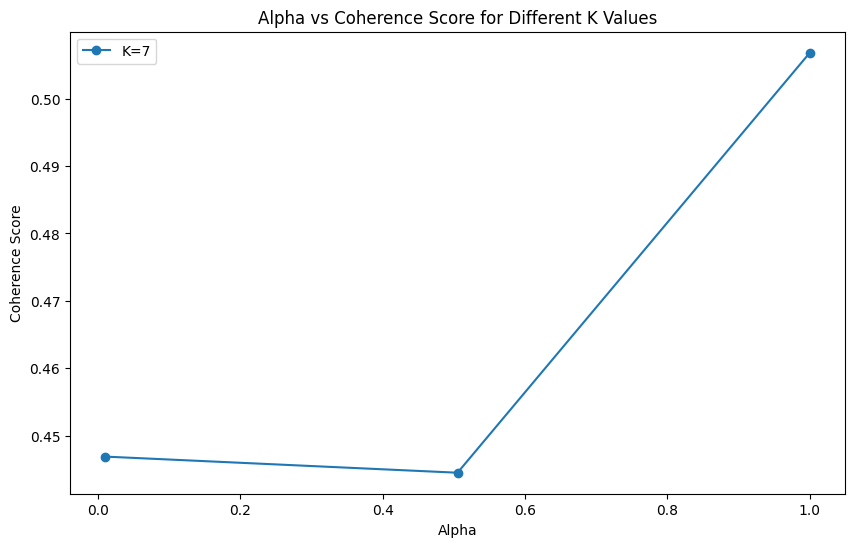


Final results:
✅ For K=7, best alpha is 1.00 with a coherence score of 0.5068


In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from itertools import combinations
from nltk.corpus import wordnet as wn

vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['concatenated'])
feature_names = vectorizer.get_feature_names_out()

max_iter = 100
alphas = np.linspace(0.01, 1, 3)
K_values = range(7,8)

plt.figure(figsize=(10, 6))

best_params = {}

for i, K in enumerate(K_values, 1):  
    print(f"[{i}/{len(K_values)}] Processing LDA for K={K}")
    coherence_scores = []
    
    for j, alpha in enumerate(alphas, 1):  
        print(f"   [{j}/{len(alphas)}] Training LDA model with alpha={alpha:.2f}")

        lda_model = LatentDirichletAllocation(n_components=K, max_iter=max_iter, random_state=42, learning_method='batch', doc_topic_prior=alpha)
        lda_model.fit(doc_term_matrix)
        
        n_top_words = 10
        top_words_per_topic = []
        for topic_idx, topic in enumerate(lda_model.components_):
            top_indices = topic.argsort()[-n_top_words:]
            top_words = [feature_names[i] for i in top_indices]
            top_words_per_topic.append(top_words)

        coherence_score = calculate_coherence(top_words_per_topic)
        coherence_scores.append(coherence_score)
    
    plt.plot(alphas, coherence_scores, marker='o', label=f'K={K}')
    
    best_alpha = alphas[np.argmax(coherence_scores)]
    best_coherence = max(coherence_scores)
    best_params[K] = (best_alpha, best_coherence)

plt.title('Alpha vs Coherence Score for Different K Values')
plt.xlabel('Alpha')
plt.ylabel('Coherence Score')
plt.legend()
plt.show()

print("\nFinal results:")
for K, (best_alpha, best_coherence) in best_params.items():
    print(f"✅ For K={K}, best alpha is {best_alpha:.2f} with a coherence score of {best_coherence:.4f}")


In [32]:
for topic_idx, words in enumerate(top_words_per_topic, 1):
    print(f"\n Topic {topic_idx}:")
    print(", ".join(words))



 Topic 1:
year, really, mental, time, wa, know, ve, help, don, depression

 Topic 2:
money, things, like, good, friends, time, school, job, work, people

 Topic 3:
shit, kill, end, hate, die, fucking, live, just, want, life

 Topic 4:
wanted, time, family, mom, said, years, friend, told, got, did

 Topic 5:
feeling, things, think, anymore, really, want, know, feel, like, just

 Topic 6:
feeling, panic, like, time, symptoms, doctor, pain, heart, stress, anxiety

 Topic 7:
thats, morning, night, today, bipolar, didnt, sleep, ive, dont, im


1. **Mental Health & Depression**  
2. **Social Life & Financial Concerns**  
3. **Suicidal Ideation & Anger**  
4. **Family & Personal Relationships**  
5. **Emotional Well-being & Self-reflection**  
6. **Anxiety & Physical Symptoms**  
7. **Bipolar Disorder & Sleep Issues**  

In [28]:
vectorizer = CountVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['concatenated'])
feature_names = vectorizer.get_feature_names_out()


coherence_score = calculate_coherence(top_words_per_topic)
print(f"Coherence Score: {coherence_score}")


K = 7  
max_iter = 400
alpha = 1.0

Coherence Score: 0.5067990060543375


NON NEGATIVE MATRIX FACTORISATION

[1/3] Running NMF with K=5...
[2/3] Running NMF with K=6...
[3/3] Running NMF with K=7...

Processing complete. Plotting results...



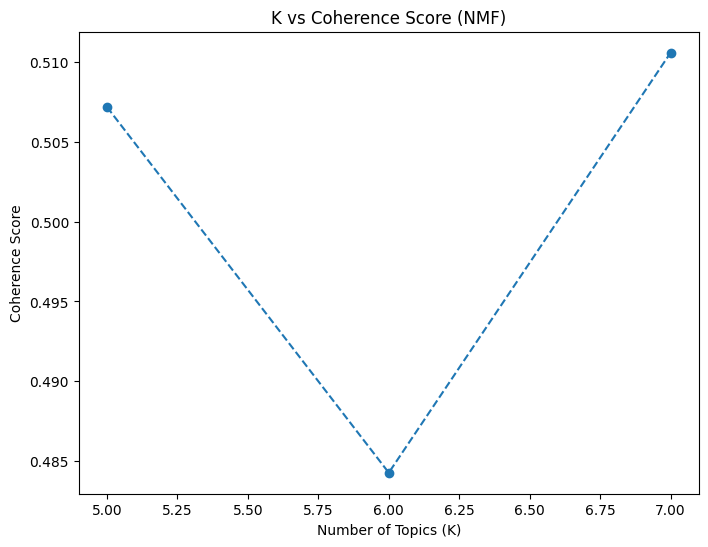

✅ The best K is 7 with a coherence score of 0.5106


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

vectorizer = TfidfVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['concatenated'])
feature_names = vectorizer.get_feature_names_out()

K_values = range(5, 8)
coherence_scores = []

def get_top_words(model, feature_names, n_top_words=10):
    top_words_per_topic = []
    for topic_idx, topic in enumerate(model.components_):
        top_indices = topic.argsort()[-n_top_words:]
        top_words = [feature_names[i] for i in top_indices]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

for i, K in enumerate(K_values, 1):
    print(f"[{i}/{len(K_values)}] Running NMF with K={K}...")

    nmf_model = NMF(n_components=K, random_state=42, init='nndsvd', max_iter=400)
    nmf_model.fit(doc_term_matrix)

    top_words_per_topic = get_top_words(nmf_model, feature_names)
    
    coherence_score = calculate_coherence(top_words_per_topic)
    coherence_scores.append(coherence_score)

print("\nProcessing complete. Plotting results...\n")

plt.figure(figsize=(8, 6))
plt.plot(K_values, coherence_scores, marker='o', linestyle='dashed')
plt.title('K vs Coherence Score (NMF)')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.show()

best_K = K_values[np.argmax(coherence_scores)]
print(f"✅ The best K is {best_K} with a coherence score of {max(coherence_scores):.4f}")


In [17]:
n_top_words = 20
top_words_per_topic = []

for topic_idx in range(7): 
    top_indices = nmf_model.components_[topic_idx].argsort()[-n_top_words:]
    top_words = [feature_names[i] for i in top_indices]
    top_words_per_topic.append(top_words)

for i, words in enumerate(top_words_per_topic):
    print(f"Topic {i+1}: {', '.join(words)}")

Topic 1: anymore, good, better, family, kill, end, world, living, wish, shit, fuck, love, friends, live, think, going, fucking, hate, people, life
Topic 2: anxious, right, restless, theres, havent, scared, anxiety, bipolar, sorry, ill, doesnt, going, didnt, sure, tired, thats, worried, nervous, ive, im
Topic 3: make, fucking, leave, suicide, tell, sleep, scared, hurt, end, pain, don, talk, stop, really, live, help, anymore, kill, die, want
Topic 4: better, bad, friends, make, happy, time, sad, way, depressed, know, does, felt, really, people, things, makes, feels, feeling, feel, like
Topic 5: week, going, job, years, started, need, wa, year, know, did, got, don, day, ve, depression, work, help, time, anxiety, really
Topic 6: ask, make, wont, need, say, whats, understand, thats, anymore, didnt, really, ive, youre, doesnt, people, worry, restless, think, know, dont
Topic 7: happy, idk, really, maybe, care, woke, trying, wake, day, point, stop, sleep, end, wish, need, talk, know, anymore,

Topic 1 → Major Depression, Suicidal Ideation

Topic 2 → Generalized Anxiety Disorder (GAD), Bipolar Disorder

Topic 3 → Severe Depression, Suicidal Ideation

Topic 4 → Depression, Mood Disorders

Topic 5 → Work-related Stress, Burnout, Depression, Anxiety Disorders

Topic 6 → Generalized Anxiety Disorder (GAD), Obsessive-Compulsive Disorder (OCD)

Topic 7 → Insomnia, Depression, Chronic Fatigue

Probabilistic Latent Semantic Analysis (PLSA)

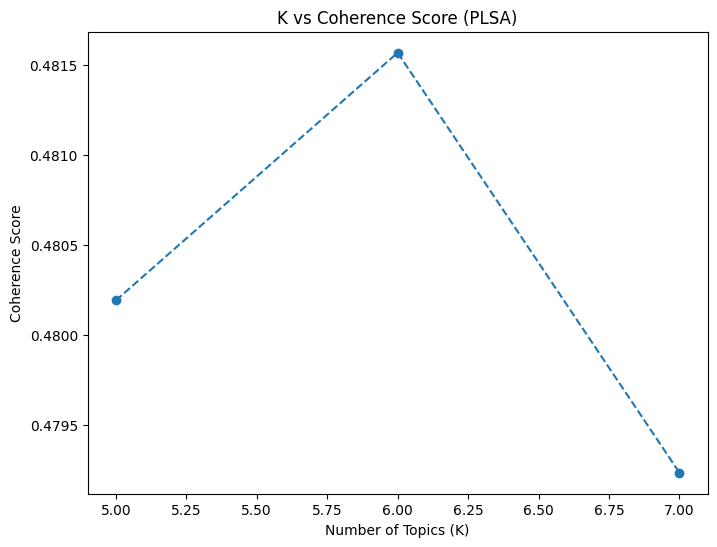

The best K is 6 with a coherence score of 0.4815682180229739


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
vectorizer = TfidfVectorizer(stop_words='english')
doc_term_matrix = vectorizer.fit_transform(df['concatenated'])
feature_names = vectorizer.get_feature_names_out()

K_values = range(5, 8)
coherence_scores = []

def get_top_words(model, feature_names, n_top_words=20):
    top_words_per_topic = []
    for topic_idx in range(model.components_.shape[0]):
        top_indices = model.components_[topic_idx].argsort()[-n_top_words:]
        top_words = [feature_names[i] for i in top_indices]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

for K in K_values:
    plsa_model = TruncatedSVD(n_components=K, random_state=42)
    plsa_model.fit(doc_term_matrix)

    top_words_per_topic = get_top_words(plsa_model, feature_names)
    
    coherence_score = calculate_coherence(top_words_per_topic)
    coherence_scores.append(coherence_score)

plt.figure(figsize=(8, 6))
plt.plot(K_values, coherence_scores, marker='o', linestyle='dashed')
plt.title('K vs Coherence Score (PLSA)')
plt.xlabel('Number of Topics (K)')
plt.ylabel('Coherence Score')
plt.show()

best_K = K_values[np.argmax(coherence_scores)]
print(f"The best K is {best_K} with a coherence score of {max(coherence_scores)}")


In [19]:

best_K = 6  
plsa_model = TruncatedSVD(n_components=best_K, random_state=42)
plsa_model.fit(doc_term_matrix)

def get_top_words(model, feature_names, n_top_words=20):
    top_words_per_topic = []
    for topic_idx in range(model.components_.shape[0]):
        top_indices = model.components_[topic_idx].argsort()[-n_top_words:]
        top_words = [feature_names[i] for i in top_indices]
        top_words_per_topic.append(top_words)
    return top_words_per_topic

top_words_per_topic = get_top_words(plsa_model, feature_names)

for i, words in enumerate(top_words_per_topic):
    print(f"Topic #{i+1}:")
    print(", ".join(words))


Topic #1:
better, feeling, did, friends, things, help, anymore, day, think, going, im, time, people, really, life, know, want, feel, like, just
Topic #2:
doctor, having, doesnt, started, time, anxious, stress, work, nervous, symptoms, like, thats, didnt, bipolar, worried, really, anxiety, ive, dont, im
Topic #3:
ill, nervous, doesnt, end, stop, restless, fuck, sleep, live, hate, ive, anymore, just, fucking, kill, tired, die, dont, im, want
Topic #4:
people, emotions, guilty, burden, anymore, numb, lonely, happy, restless, tired, sad, makes, just, want, feeling, feels, im, dont, like, feel
Topic #5:
health, ll, doctor, didn, panic, feeling, ha, depression, need, feel, talk, wa, help, really, anxiety, ve, know, dont, don, want
Topic #6:
make, suicide, live, good, family, care, things, friend, person, say, really, talk, think, love, friends, did, life, know, people, dont


Topic 1 → Depression, Emotional Distress

Topic 2 → Anxiety Disorders, Bipolar Disorder, Work-related Stress

Topic 3 → Suicidal Ideation, Severe Depression, Restlessness

Topic 4 → Depression, Loneliness, Emotional Numbness

Topic 5 → Panic Disorder, Depression, Generalized Anxiety Disorder (GAD)

Topic 6 → Suicidal Ideation, Depression, Existential Distress